In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
def random_colours(number_of_colors):
    '''
    #function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

Read the data (train and test)

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Dropping any null value


In [6]:
train.dropna(inplace=True)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


No missing values in the test dataset

Now let's deep dive into the data :)

In [8]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [10]:
train.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


There are 11117 neutral tweets :|, 
          7781 negative tweets :(, 
      and 8582 positive tweets :).

In [11]:
px.histogram(train, x='sentiment', color= 'sentiment',barmode='group')

In [12]:
px.histogram(test, x='sentiment', color= 'sentiment',barmode='group')

our aim is not to predict these labels (positive, negative, neutral),but to predict the selected text which can help us figure out the sentiment of the tweet

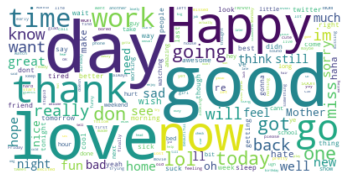

In [13]:
#Importing Libraries

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from wordcloud import WordCloud

#Creating the text variable

text1 = " ".join(title for title in train['selected_text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text1)

# Display the generated Word Cloud

plt.imshow(word_cloud1, interpolation='bilinear')

plt.axis("off")

plt.show()

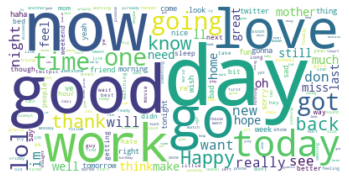

In [14]:
text2 = " ".join(title for title in train['text'])

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud

plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()

In [15]:
train_positive = train[train['sentiment']=='positive']
train_negative = train[train['sentiment']=='negative']
train_neutral = train[train['sentiment']=='neutral']

In [16]:
train_neutral.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,50e14c0bb8,Soooo high,Soooo high,neutral


In [17]:
text3 = " ".join(title for title in train_positive['text'])
text4 = " ".join(title for title in train_negative['text'])
text5 = " ".join(title for title in train_neutral['text'])
# Creating word_cloud with text as argument in .generate() method

word_cloud3 = WordCloud(collocations = False, background_color = 'white').generate(text3)

word_cloud4 = WordCloud(collocations = False, background_color = 'white').generate(text4)

word_cloud5 = WordCloud(collocations = False, background_color = 'white').generate(text5)


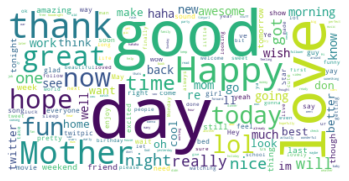

In [18]:
# Display the generated Word Cloud for positive text

plt.imshow(word_cloud3, interpolation='bilinear')

plt.axis("off")

plt.show()

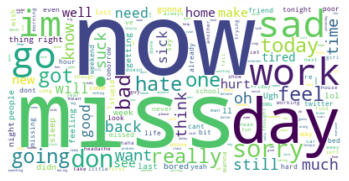

In [19]:
# Display the generated Word Cloud for negative text

plt.imshow(word_cloud4, interpolation='bilinear')

plt.axis("off")

plt.show()

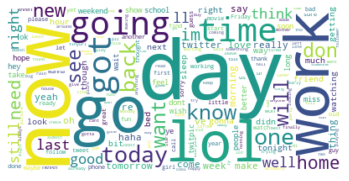

In [20]:
# Display the generated Word Cloud for neutral text

plt.imshow(word_cloud5, interpolation='bilinear')

plt.axis("off")

plt.show()

we have to predict selected_text which is a subset of text, so we need to create features :-

1. Difference In Number Of words of Selected_text and Text
2. Jaccard Similarity Scores between text and Selected_text (0-1) , 1 being equal number of words in selected_text and text

In [21]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [22]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [23]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [24]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [25]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [26]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

the number of words distribution plot is right skewed, as we have very less tweets which have greater than 20 words

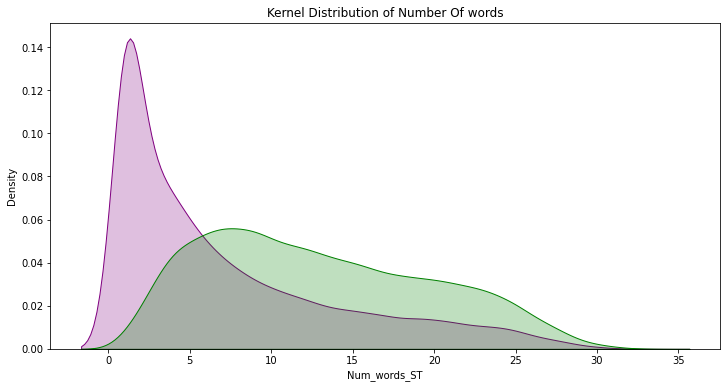

In [27]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="purple").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="green")

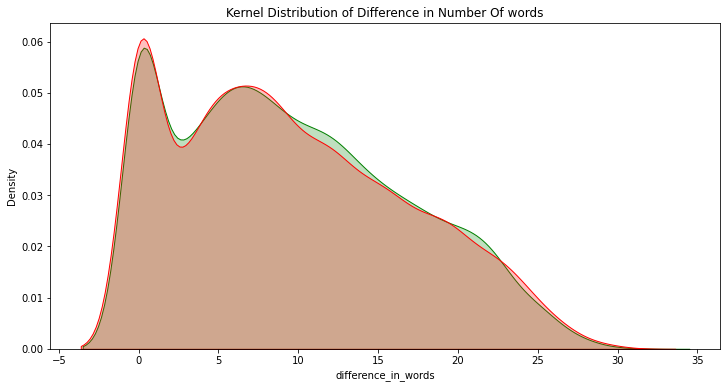

In [28]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="green").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="red")
#almost the same

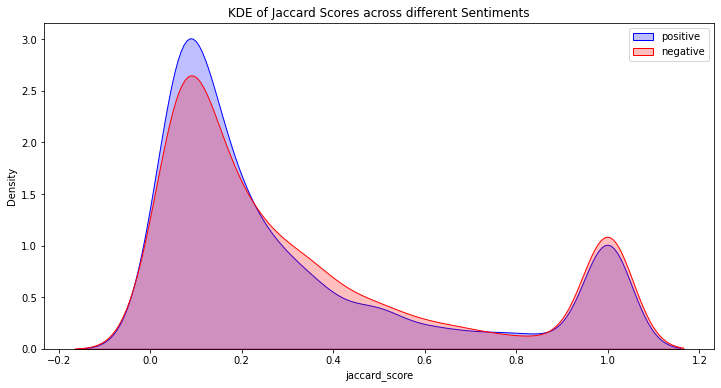

In [29]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

**Interesting finds:**
For both the graph difference in number of words and jaccard score the Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density. 

**kurtosis :** Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak

**skewness :** Skewness measures how much a curve deviates from a normal distribution

**More insights from the above two graphs**

We can see from both the graphs, when the difference in words is zero and the jaccard score is 1, there is a peak in density for both positive and negative tweets.

one reason for this could be, for tweets with less number of words, the number of words for selected text and number of words for text is mostly same, and thua creating a cluster of data with same number of words in text and selected text.

In [30]:
small_tweets = train[train['Num_word_text']<=3]

here we are creating a df with number of words less than equal to 3

In [31]:
small_tweets[small_tweets['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.000000,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.000000,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.000000,2,2,0
276,894e188d01,HAPPY MOTHERS DAY.!,HAPPY,positive,0.333333,1,3,2
278,89d5b3f0b5,Thanks,Thanks,positive,1.000000,1,1,0
...,...,...,...,...,...,...,...,...
26990,86b7715bfb,good morning everbody!,good morning everbody!,positive,1.000000,3,3,0
27292,47c474aaf1,Good choice,Good,positive,0.500000,1,2,1
27369,085522592b,today was interesting...,today was interesting...,positive,1.000000,3,3,0
27433,0a43c46417,Really good night,Really good night,positive,1.000000,3,3,0


In [32]:
small_tweets.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.704638
neutral     0.982383
positive    0.695925
Name: jaccard_score, dtype: float64

In [33]:
small_tweets.groupby('sentiment').mean()['difference_in_words']

sentiment
negative    0.724771
neutral     0.023490
positive    0.715859
Name: difference_in_words, dtype: float64

We can see that there is similarity between text and selected text.

#cleaning the data


In [34]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [35]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [36]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


Removing stopwords

In [37]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['templist'] = train['selected_text'].apply(lambda x:str(x).split())
train['templist'] = train['templist'].apply(lambda x:remove_stopword(x))
train['templist1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['templist1'] = train['templist1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [42]:
top = Counter([item for sublist in train['templist'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [43]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [47]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [44]:
top1 = Counter([item for sublist in train['templist1'] for item in sublist])
temp1 = pd.DataFrame(top1.most_common(25))
temp1 = temp1.iloc[1:,:]
temp1.columns = ['Common_words','count']
temp1.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [46]:
fig = px.bar(temp1, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

Now let's check the most common words in different sentiments

In [48]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [64]:
Positive_sent.head(3)

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,templist,templist1
6,6e0c6d75b1,feedings for the baby are fun when he is all ...,fun,positive,0.071429,1,14,13,[fun],"[feedings, baby, fun, smiles, coos]"
9,fc2cbefa9d,journey wow u just became cooler hehe is tha...,wow u just became cooler,positive,0.500000,5,10,5,"[wow, u, became, cooler]","[journey, wow, u, became, cooler, hehe, possible]"
11,16fab9f95b,i really really like the song love story by ta...,like,positive,0.100000,1,11,10,[like],"[really, really, like, song, love, story, tayl..."


In [49]:
#MosT common positive words
top_positive = Counter([item for sublist in Positive_sent['templist'] for item in sublist])
temp_positive = pd.DataFrame(top_positive.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [50]:
#MosT common positive words
top_negative = Counter([item for sublist in Negative_sent['templist'] for item in sublist])
temp_negative = pd.DataFrame(top_negative.most_common(20))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
0,im,452
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162


In [53]:
#MosT common positive words
top_neutral = Counter([item for sublist in Neutral_sent['templist'] for item in sublist])
temp_neutral = pd.DataFrame(top_neutral.most_common(20))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
0,im,1039
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427


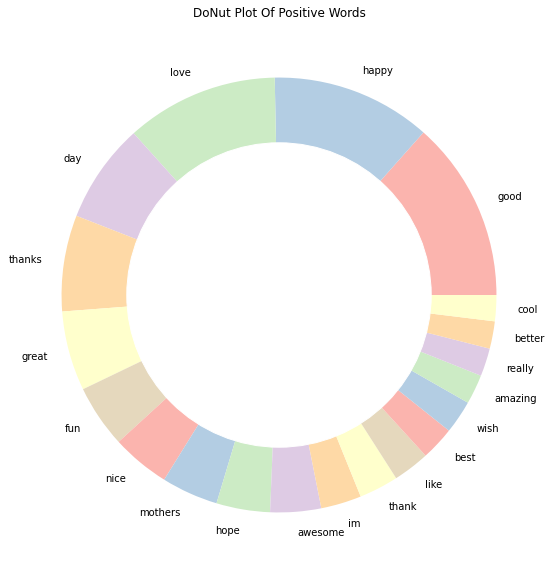

In [56]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_positive['count'], labels=temp_positive.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Positive Words')
plt.show()

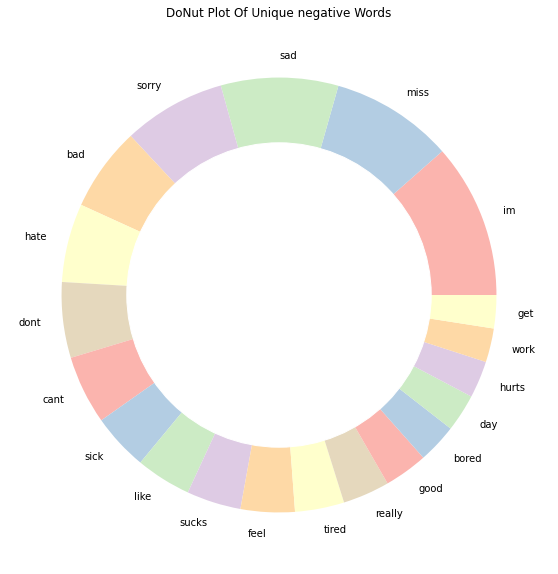

In [57]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_negative['count'], labels=temp_negative.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique negative Words')
plt.show()

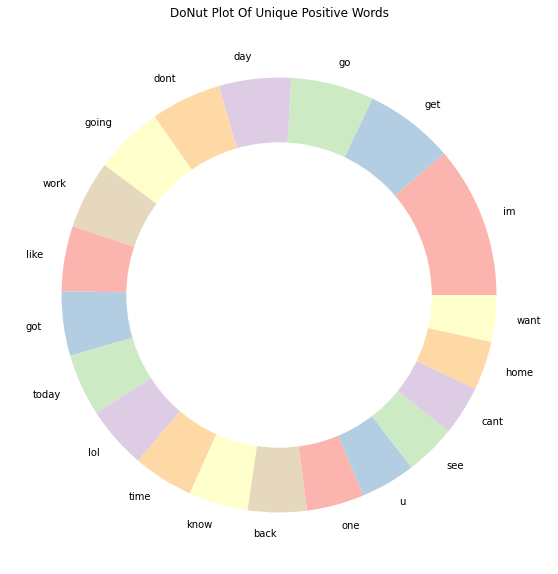

In [55]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_neutral['count'], labels=temp_neutral.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [58]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

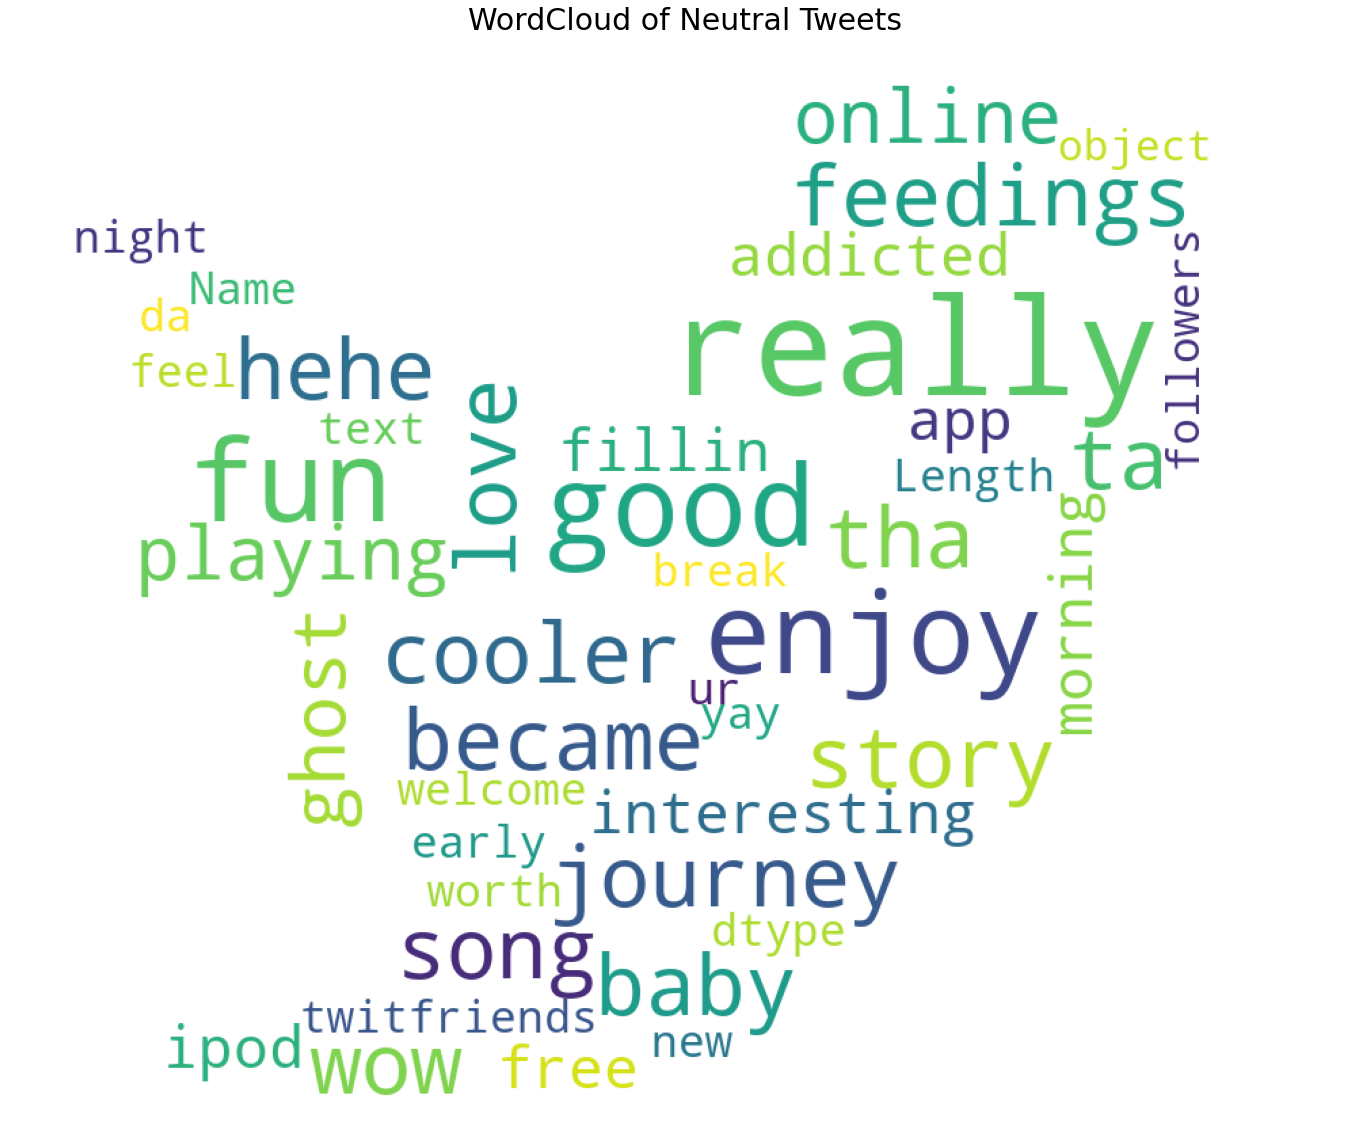

In [65]:
pos_mask = np.array(Image.open('/content/twitter_mask.png'))
plot_wordcloud(Positive_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

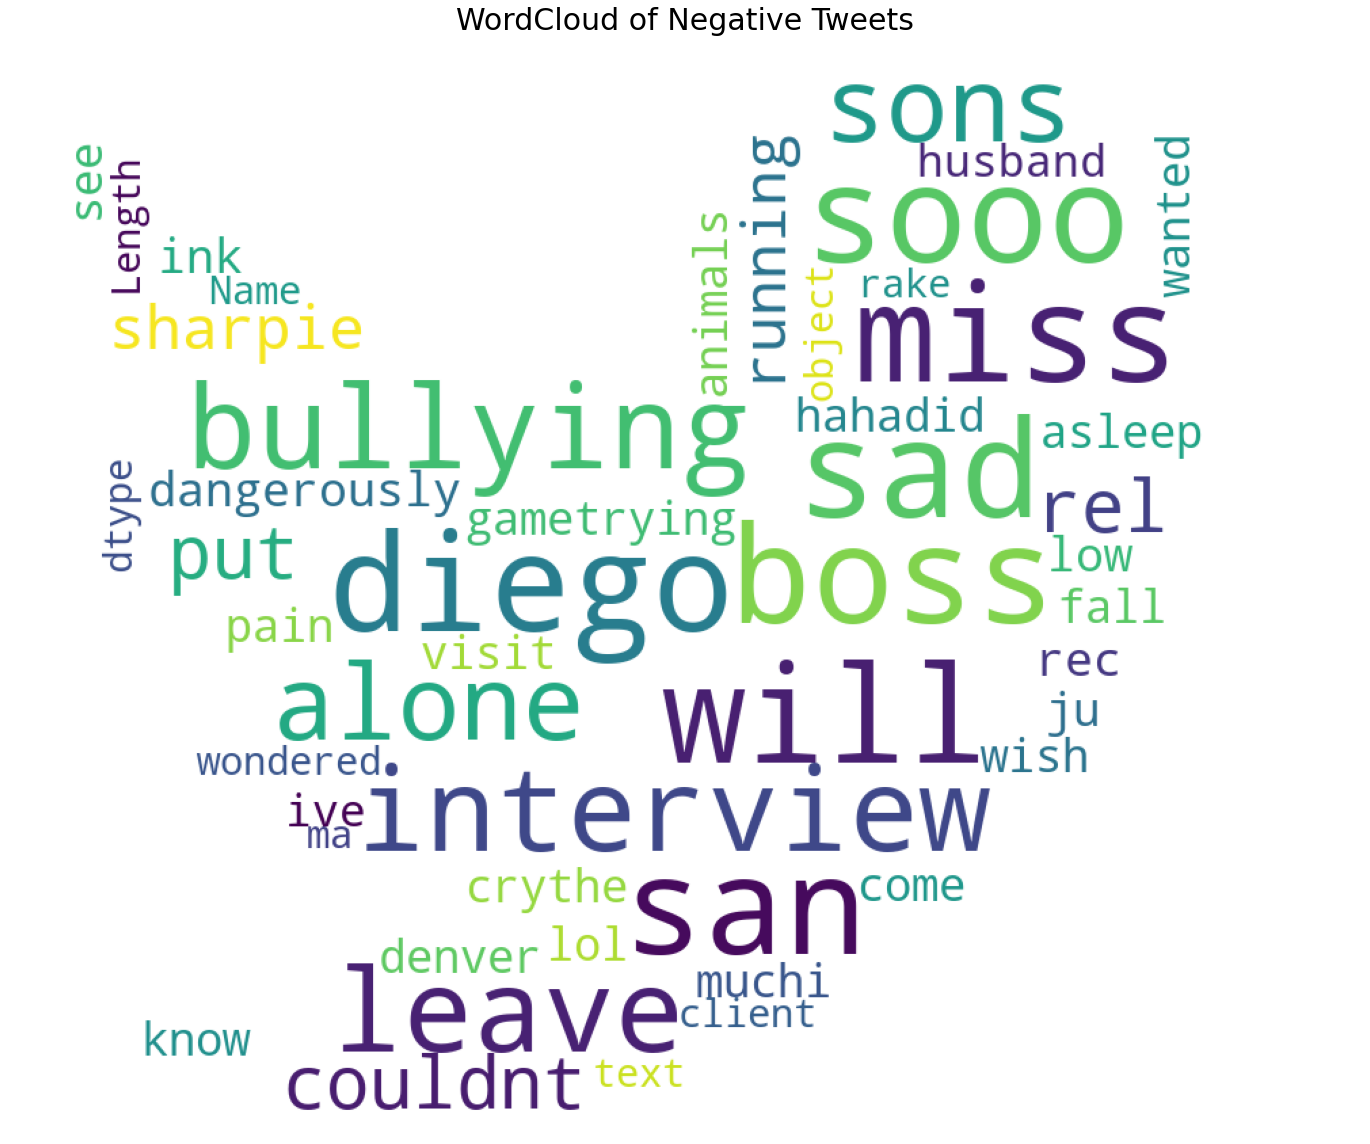

In [66]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

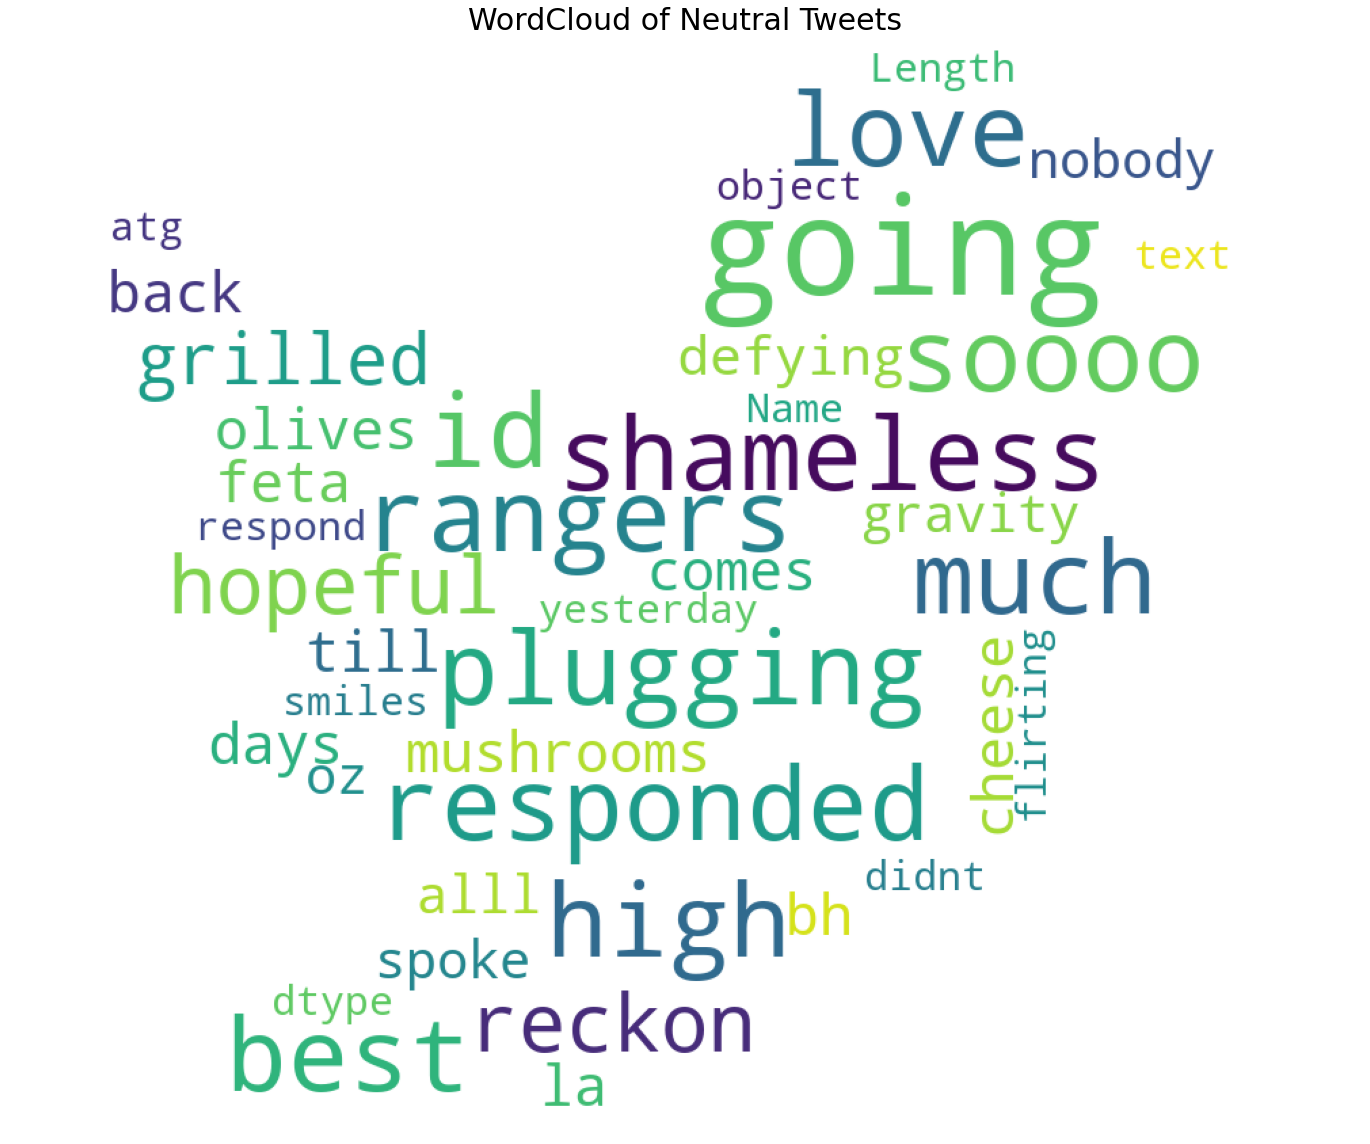

In [70]:
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")